In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# measurments - aproximate (non-reliable)
weights = [158.0, 164.2, 160.3, 159.9, 162.1, 164.6, 169.6, 167.4, 166.4, 171.0, 171.2, 172.6]


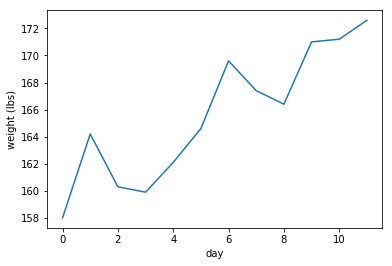

In [5]:
# measurment graph
plt.plot(weights)
plt.xlabel('day')
plt.ylabel('weight (lbs)')
plt.show()

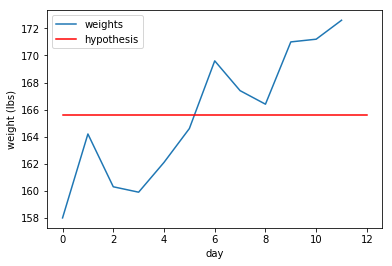

In [7]:
# measurments with average line: average is real weight hypothesis
ave = np.sum(weights) / len(weights)
plt.plot(weights, label='weights')
plt.plot([0,12], [ave,ave], c='r', label='hypothesis')
plt.xlabel('day')
plt.ylabel('weight (lbs)')
plt.legend(loc='best')
plt.show()

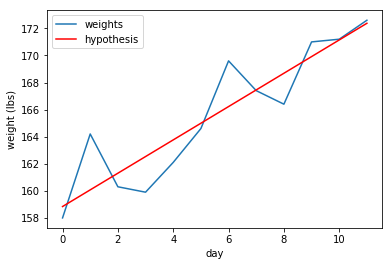

In [9]:
# using 'least squares fit' to get real weight (hypothesis)
xs = range(len(weights))
line = np.poly1d(np.polyfit(xs, weights, 1))
plt.plot(weights, label='weights')
plt.plot (xs, line(xs), c='r', label='hypothesis')
plt.xlabel('day')
plt.ylabel('weight (lbs)')
plt.legend(loc='best')
plt.show()

In [13]:
# predict using actual gain rate, measurment and scale factor 
# weight = prediction + scale_factor * (measurment - prediction)
# we are expressing a belief that the prediction is somewhat more likely to be correct than the measurement (scale_factor). 
def predict_using_gain_guess(weights, weight, gain_rate, scale_factor, time_step=1): # store the filtered results
    estimates = []
    for z in weights:
        # predict new position
        prediction = weight + gain_rate * time_step
        # update filter
        weight = prediction + scale_factor * (z - prediction) # save for plotting
        estimates.append(weight)
    # plot results
    n = len(weights)
    plt.xlim([1, n])
    plt.plot (range(1, n+1), estimates, '--', label='filter')
    plt.plot(range(1, n+1), weights, c='r', label='measurements')
    plt.plot([1, n], [160, 160+n], c='g', label='actual')
    plt.legend(loc=2)
    plt.xlabel('day')
    plt.ylabel('weight (lbs)')
    plt.show()


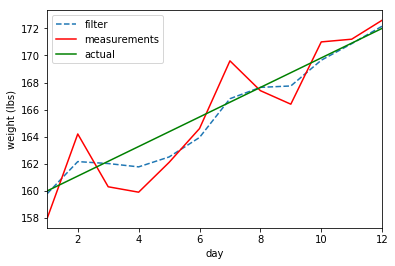

In [14]:
time_step = 1 # day 
scale_factor = 4/10

predict_using_gain_guess (weights, weight=160, gain_rate=1, scale_factor=scale_factor, time_step=1)

In [19]:
# predict using actual gain rate, measurment and scale factor 
# weight = prediction + scale_factor * (measurment - prediction)
# we are expressing a belief that the prediction is somewhat more likely to be correct than the measurement (scale_factor). 
# gain_rate = gain_rate + gain_scale * ( (measurment - weight)/time_step)
def predict_using_dynamic_gain_guess(weights, weight, gain_rate, gain_scale, weight_scale, time_step=1): 
    estimates = []
    for z in weights:
        # prediction step
        weight = weight + gain_rate*time_step 
        # update step
        residual = z - weight
        gain_rate = gain_rate + gain_scale * (residual/time_step)
        weight = weight + weight_scale * residual
        
        estimates.append(weight)
        
    # plot results
    n = len(weights)
    plt.xlim([1, n])
    plt.plot (range(1, n+1), estimates, '--', label='filter')
    plt.plot(range(1, n+1), weights, c='r', label='measurements')
    plt.plot([1, n], [160, 160+n], c='g', label='actual')
    plt.legend(loc=2)
    plt.xlabel('day')
    plt.ylabel('weight (lbs)')
    plt.show()

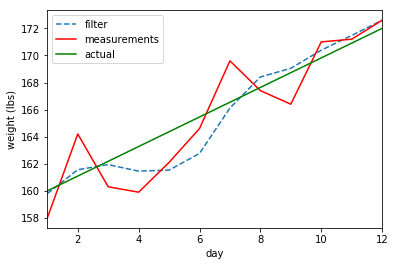

In [20]:

predict_using_dynamic_gain_guess (weights, weight=160, gain_rate=1, gain_scale=1/3, weight_scale=scale_factor, time_step=1)


In [53]:
def g_h_filter (data, x0, dx, g, h, dt=1., pred=None):
    """
    Performs g-h filter on 1 state variable with a fixed g and h.
    ’data’ contains the data to be filtered.
    ’x0’ is the initial value for our state variable
    ’dx’ is the initial change rate for our state variable
    ’g’ is the g-h’s g scale factor
    ’h’ is the g-h’s h scale factor
    ’dt’ is the length of the time step
    """
    x = x0
    estimates = []
    for z in data:
        # prediction step
        x_est = x + dx * dt
        if pred is not None: pred.append(x_est)
        # update step
        residual = z - x_est
        dx = dx + h * (residual/dt)
        x = x_est + g * residual
        
        estimates.append(x) 
    return estimates    

def plot_g_h_results (measurements, filtered_data, title='', prediction = None):
    plt.plot (filtered_data, '--', label='filter')
    plt.plot(measurements, label='measurement')
    if prediction:
        plt.plot(prediction, label='prediction')
    plt.legend(loc=4)
    plt.title(title)
    plt.show()

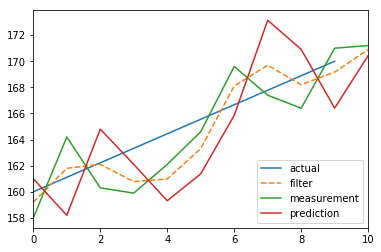

In [55]:
plt.xlim([0,10])
plt.plot([0,9],[160,170],label='actual')
pred = []
data = g_h_filter (data=weights, x0=160, dx=1, g=6./10, h = 2./3, dt=1., pred = pred)
plot_g_h_results (weights, data, prediction=pred)

In [35]:
#sample data generator
#acceleration : how dx increases
def gen_data (x0, dx, count, noise_factor, acceleration = 0):
    res = []
    for i in range (count):
        res.append(x0 + dx*i + np.random.randn() * noise_factor)
        dx += acceleration
    return res    


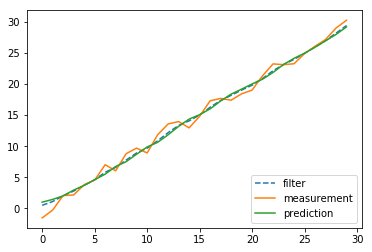

In [56]:
measurements = gen_data(0, 1, 30, 1)
pred = []
data = g_h_filter (data=measurements, x0=0, dx=1, dt=1, g=.2, h=0.02, pred = pred)
plot_g_h_results (measurements, data, prediction=pred)


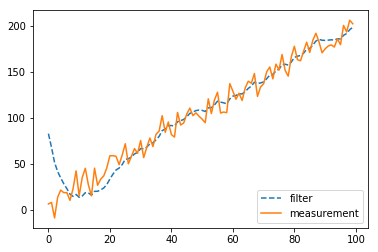

In [57]:
# estimates that are far from the measured data due to the bad initial guess of 100
# 'ringing'
measurements = gen_data(5, 2, 100, 10)
data = g_h_filter (data=measurements, x0=100, dx=2, dt=1, g=.2, h=0.02)
plot_g_h_results (measurements, data)

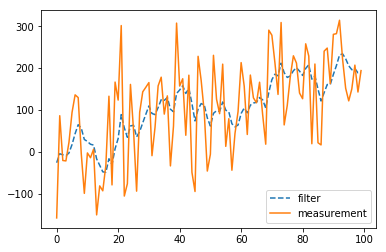

In [38]:
# noise factor of 100. Remove the initial condition ringing by changing the initial condition from 100 down to 5.
# we added a lot of noise
measurements = gen_data(5, 2, 100, 100)
data = g_h_filter (data=measurements, x0=5, dx=2, dt=1, g=.2, h=0.02)
plot_g_h_results (measurements, data)

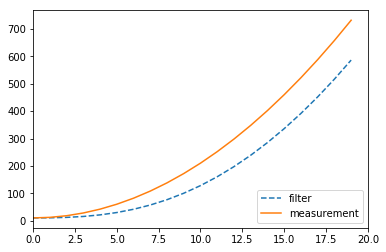

In [43]:
#Using accelertion: Each prediction lags behind the signal. 
#If you think about what is happening this makes sense. 
#Our model assumes that velocity is constant. 
#The g-h filter computes the first derivative of x (we use x ̇ to denote the derivative) 
#but not the second derivative x ̈.
predictions = []
measurements = gen_data (x0=10, dx=0, count=20, noise_factor=0, acceleration = 2)
data = g_h_filter (data=measurements, x0=10, dx=0, g=0.2, h=0.02, pred=predictions)
plt.xlim([0,20])
plot_g_h_results  (measurements=measurements, filtered_data=data)


### Note that there is no adjustment to g or h that we can make to correct this problem. 
### This is called the lag error or systemic error of the system. It is a fundamental property of g-h filters.

In [44]:
# let the noise factor=50 and dx=5. Plot the results of g = 0.1, 0.5, and 0.9.
measurements = gen_data(5, 5, 100, 50)


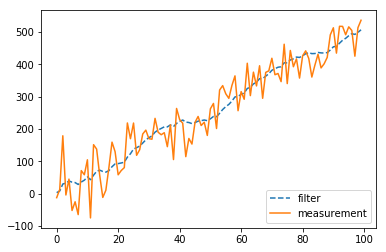

In [45]:
data = g_h_filter (data=measurements, x0=0, dx=5, dt=1, g=.1, h=0.01)
plot_g_h_results (measurements, data)

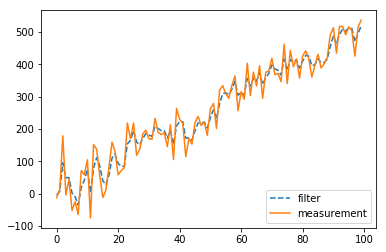

In [46]:
data = g_h_filter (data=measurements, x0=0, dx=5, dt=1, g=.5, h=0.01)
plot_g_h_results (measurements, data)

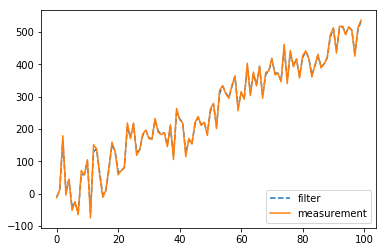

In [47]:
data = g_h_filter (data=measurements, x0=0, dx=5, dt=1, g=.9, h=0.01)
plot_g_h_results (measurements, data)

It is clear that as g is larger we more closely follow the measurement instead of the prediction. When g = 0.9 we follow the signal almost exactly, and reject almost none of the noise. One might naively conclude that g should always be very small to maximize noise rejection. However, that means that we are mostly ignoring the measurements in favor of our prediction.

In [49]:

measurements = [5,6,7,8,9,10,11,12,13,14]
for i in range(100): 
    measurements.append(14)


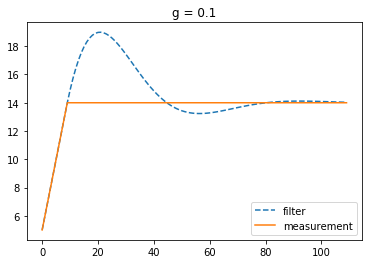

In [50]:
data = g_h_filter (data=measurements, x0=4., dx=1., dt=1.,g=0.1, h=0.01)
plot_g_h_results  (measurements, data, 'g = 0.1')


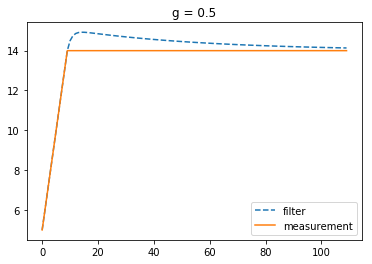

In [51]:
data = g_h_filter (data=measurements, x0=4., dx=1., dt=1.,g=0.5, h=0.01)
plot_g_h_results  (measurements, data, 'g = 0.5')


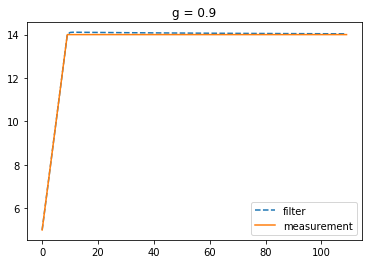

In [52]:
data = g_h_filter (data=measurements, x0=4., dx=1., dt=1.,g=0.9, h=0.01)
plot_g_h_results  (measurements, data, 'g = 0.9')

### Changing h

In [58]:

measurements = np.linspace(0,1,50)


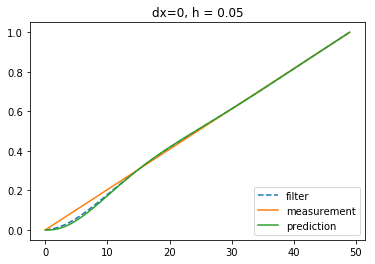

In [63]:
pred=[]
data = g_h_filter (data=measurements, x0=0, dx=0., dt=1.,g=.2, h=0.05, pred=pred)
plot_g_h_results  (measurements, data, 'dx=0, h = 0.05', prediction=pred)


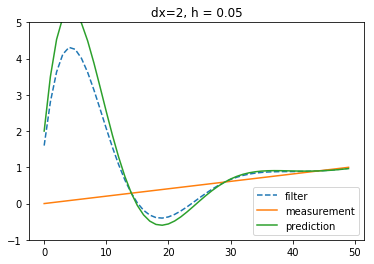

In [66]:
pred=[]
data = g_h_filter (data=measurements, x0=0, dx=2., dt=1.,g=.2, h=0.05, pred=pred)
plt.ylim([-1,5])
plot_g_h_results  (measurements, data, 'dx=2, h = 0.05', prediction=pred)


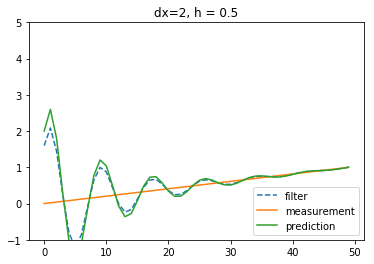

In [67]:
pred=[]
data = g_h_filter (data=measurements, x0=0, dx=2., dt=1.,g=.2, h=0.5, pred=pred)
plt.ylim([-1,5])
plot_g_h_results  (measurements, data, 'dx=2, h = 0.5', prediction=pred)